子图是指将LangGraph图作为节点在在另一个图中使用。子图非常有用，主要体现在以下几个方面：
- 构建多智能体系统
- 在多个图中复用一组节点
- 分布式开发：当你希望不同的团队独立开发图的不同部分时，你可以将每个部分定义为一个子图。只要子图的接口（输入和输出模式）得到遵守，父图就可以在不了解子图任何细节的情况下进行构建。

# 父子图之间的通讯方式

## 从节点调用子图

子图是一个独立的、可复用的功能模块，对于主图来讲，有点像叫外卖：
  - 执行流程：控制权转移。
    - 父图运行到某个节点（Node），该节点的代码中显式调用了 subgraph.invoke()。
    - 父图暂停，控制权完全交给子图。
    - 子图独立运行完毕（可能包含多个节点和循环），直到结束。
    - 子图将最终结果返回给父图的该节点，父图继续向下执行。
  - 状态管理：隔离。
    - 父图和子图`拥有各自独立的状态（State）`。
    - 你需要显式地将父图的数据作为输入传给子图。
    - 子图处理完后，必须显式地返回结果给父图。
  - 优点：
    - 高内聚，低耦合：子图像一个黑盒，可以在不同的父图中复用。
    - 逻辑清晰：适合将复杂的逻辑封装起来（例如：一个专门用来做“市场调研”的子图）。

In [27]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

class SubgraphState(TypedDict):
    bar: str

# Subgraph
# 独立的状态state
def subgraph_node_1(state: SubgraphState):
    return {"bar": "hi! " + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph = subgraph_builder.compile()

# Parent graph
class State(TypedDict):
    foo: str

def call_subgraph(state: State):
    # Transform the state to the subgraph state
    subgraph_output = subgraph.invoke({"bar": state["foo"]})  
    # Transform response back to the parent state
    return {"foo": subgraph_output["bar"]}

builder = StateGraph(State)
builder.add_node("node_1", call_subgraph)
builder.add_edge(START, "node_1")
graph = builder.compile()

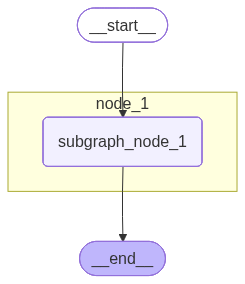

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
result = graph.invoke({"foo": "pet"})
result


{'foo': 'hi! pet'}

### 两级子图

In [31]:
# 孙级子图 (Grandchild graph)
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END

class GrandChildState(TypedDict):
    my_grandchild_key: str

def grandchild_1(state: GrandChildState) -> GrandChildState:
    # 注意：此处无法访问子级或父级的键
    return {"my_grandchild_key": state["my_grandchild_key"] + ", how are you"}

# 构建孙级图
grandchild = StateGraph(GrandChildState)
grandchild.add_node("grandchild_1", grandchild_1)

grandchild.add_edge(START, "grandchild_1")
grandchild.add_edge("grandchild_1", END)

grandchild_graph = grandchild.compile()

# 子级图 (Child graph)
class ChildState(TypedDict):
    my_child_key: str

def call_grandchild_graph(state: ChildState) -> ChildState:
    # 注意：此处无法访问父级或孙级的键
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": grandchild_graph_output["my_grandchild_key"] + " today?"}

child = StateGraph(ChildState)
# 这里传入的是一个函数，而不仅仅是编译好的图对象 (`grandchild_graph`)
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
child_graph = child.compile()

# 父级图 (Parent graph)
class ParentState(TypedDict):
    my_key: str

def parent_1(state: ParentState) -> ParentState:
    # 注意：此处无法访问子级或孙级的键
    return {"my_key": "hi " + state["my_key"]}

def parent_2(state: ParentState) -> ParentState:
    return {"my_key": state["my_key"] + " bye!"}

def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_key"]}
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_key": child_graph_output["my_child_key"]}

parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)
# 这里传入的是一个函数，而不仅仅是编译好的图对象 (`child_graph`)
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

parent_graph = parent.compile()

# 流式输出，subgraphs=True 会显示子图的输出
for chunk in parent_graph.stream({"my_key": "Bob"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_key': 'hi Bob'}})
(('child:44403b58-208c-1cb9-064e-4b6fc6d2577a', 'child_1:e38b7d12-8adc-3b98-8a0d-263b52bc5d35'), {'grandchild_1': {'my_grandchild_key': 'hi Bob, how are you'}})
(('child:44403b58-208c-1cb9-064e-4b6fc6d2577a',), {'child_1': {'my_child_key': 'hi Bob, how are you today?'}})
((), {'child': {'my_key': 'hi Bob, how are you today?'}})
((), {'parent_2': {'my_key': 'hi Bob, how are you today? bye!'}})


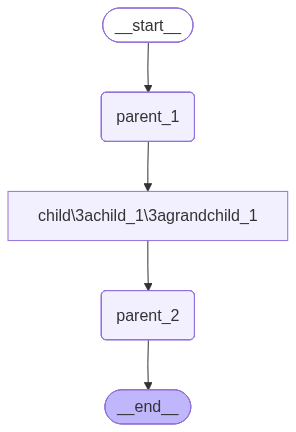

In [32]:
from IPython.display import Image, display

display(Image(parent_graph.get_graph(xray=True).draw_mermaid_png()))

## 将图添加为节点

将子图直接作为节点添加到父图中，并与父图`共享状态键（State Keys）`，是父图工作流的一个有机组成部分，需要频繁交换数据，类似于请厨师回家做饭：
  - 执行流程：边流入边执行。
    - 子图被注册为父图中的一个特殊节点。
    - 当父图的执行流进入这个“子图节点”时，它会逐步执行子图内部的节点。
    - 子图内部的节点和父图的其他节点一样，共享同一个状态池。
  - 状态管理：共享。
    - 父图和子图读写同一份状态数据（State Keys）。
    - 不需要显式的输入/输出传递，子图可以直接读取父图状态中的某些字段，并直接修改它。
  - 优点：
    - 数据共享方便：不需要繁琐的数据打包和解包。
    - 分布式开发：适合大型项目，不同团队负责不同的子图部分，最后通过共享状态接口拼装在一起。

In [33]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# 定义子图
class SubgraphState(TypedDict):
    foo: str  # 与父图状态共享
    bar: str  # 仅 SubgraphState 私有

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    # 注意：该节点使用了一个仅在子图中可用的状态键（'bar'）
    # 并且正在更新共享的状态键（'foo'）
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# 定义父图
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph) # 将编译好的子图直接作为节点添加
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

{'node_1': {'foo': 'hi! foo'}}
{'node_2': {'foo': 'hi! foobar'}}


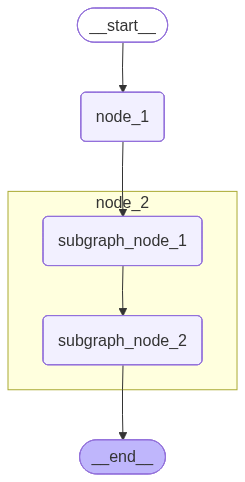

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 使用Command导航到父图

如果你正在使用子图（subgraphs），但希望从子图内的某个节点直接跳转到另一个不同的子图（即父图中的不同节点），你可以在 Command 中指定 graph=Command.PARENT来实现这个需求。

In [ ]:
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # `other_subgraph` 是在父图中的一个节点
        graph=Command.PARENT
    )

In [38]:
from langgraph.graph import StateGraph, START
from langgraph.types import Command
import operator
import random
from typing_extensions import Annotated, Literal

class State(TypedDict):
    # 共享键，必须在父图的状态定义中为该键定义一个归约函数（reducer）
    foo: Annotated[str, operator.add]  

def node_a(state: State): # 这里不能指定Command的可选节点，因为他们不是在子图中定义的
    print("Called A")
    value = random.choice(["b", "c"])
    if value == "b":
        goto = "node_b"
    else:
        goto = "node_c"

  
    return Command(
        update={"foo": value},
        goto=goto,
        # 指示 LangGraph 导航至父图中的 node_b 或 node_c
        # 注意：这将导航至相对于子图的最近一层父图
        graph=Command.PARENT,  
    )

subgraph = StateGraph(State).add_node(node_a).add_edge(START, "node_a").compile()

def node_b(state: State):
    print("Called B")
    return {"foo": "b"}  

def node_c(state: State):
    print("Called C")
    return {"foo": "c"}  

builder = StateGraph(State)
builder.add_node("subgraph", subgraph)
builder.add_node(node_b)
builder.add_node(node_c)
builder.add_edge(START, "subgraph")

graph = builder.compile()

In [39]:
result = graph.invoke({"foo": "a"})
result

Called A
Called B


{'foo': 'abb'}